## Deep learning with Keras: Chest accelerometer data

Dataset from https://archive.ics.uci.edu/ml/datasets/Activity+Recognition+from+Single+Chest-Mounted+Accelerometer

In [1]:
# Set a seed for reproducibility
import numpy as np
seed = 42
np.random.seed(seed)

In [2]:
import glob
data_files = glob.glob("activity/*.csv")

# Initialise array for data:
#   Rows will be observations
#   Columns will be:
#   * Time point (sequential count integer)
#   * x-, y-, z-directional accelerometer data time series (integer)
#   * Activity label (1-7)
#   * Person label (0-14)
dataset = np.empty((0, 6), dtype = "float64")

# Add data from each file in turn
for i in range(len(data_files)):
    
    print("Reading file", i+1, "/", len(data_files))
    
    f = data_files[i]
    data = np.genfromtxt(f, delimiter=',')
    
    # Add a column with a label representing the person
    # (this doesn't necessarily line up with the file number)
    augmented = np.column_stack(
        (data, np.array([i]*data.shape[0]))
    )
    dataset = np.vstack((dataset, augmented))

Reading file 1 / 15
Reading file 2 / 15
Reading file 3 / 15
Reading file 4 / 15
Reading file 5 / 15
Reading file 6 / 15
Reading file 7 / 15
Reading file 8 / 15
Reading file 9 / 15
Reading file 10 / 15
Reading file 11 / 15
Reading file 12 / 15
Reading file 13 / 15
Reading file 14 / 15
Reading file 15 / 15


In [3]:
# Check how many observations we have
dataset.shape

(1926896, 6)

In [4]:
# Reshape data into 3 dimensions:
#   0-dimension ("rows") is observations (1926896 in total)
#   1-dimension ("columns") is time series values (260 = 5{seconds}*52{Hz} in total)
#   2-dimension ("leaves") are as follows (5 in total):
#     * 3 directions (x-, y-, z-acceleration)
#     * Activity type labels
#     * Person labels

# We'll chop the time series into 260-length (5 second) sections every 52 points (every 1 second)
t = int((dataset.shape[0]-208) / 52)
chopped = -np.ones((t, 260, 5), dtype="float64")

for k in range(0, t):
    start, stop = (52*k, 52*k + 260)
    # If the count column's value at "stop" is smaller than at "start", we've changed person, so discard
    # If the activity label column is not all the same, we have more than one activity in that section, so discard
    if (dataset[stop, 0] < dataset[start, 0] or not all(dataset[start:stop, 4] == dataset[start, 4])):
        continue
    # Else copy all but count column to the new data block
    chopped[k, :, :] = dataset[start:stop, 1:6]

# Remove the extra rows, which will have person label -1
chopped = chopped[(chopped[:, 0, 4] != -1), :, :]

In [5]:
chopped.shape

(36363, 260, 5)

Visual representation of `chopped`. Each observation (row) has 260 time points (columns) and 5 features (layers).
![](tensor.png)

---

## Problem 1: Identify person based on gait

In [6]:
import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

Using TensorFlow backend.


In [7]:
# "Walking" corresponds to activity label 4
walking = chopped[(chopped[:, 0, 3] == 4), :, :]

### Preparing the data

In [8]:
m = walking.shape[0]
from random import shuffle
indices = [x for x in range(m)]
shuffle(indices)
train_indices = indices[:int(m*0.6)]
val_indices = indices[int(m*0.6):int(m*0.8)]
test_indices = indices[int(m*0.8):]

In [9]:
from sklearn.preprocessing import scale
from keras.utils import to_categorical

# Time series data is in layers 0 to 2
# Neural nets need scaled and ideally 0-centred data
X_train = np.apply_along_axis(lambda x: scale(x.reshape(1, -1), axis=1), 1, walking[train_indices, :, 0:3])
X_val = np.apply_along_axis(lambda x: scale(x.reshape(1, -1), axis=1), 1, walking[val_indices, :, 0:3])
X_test = np.apply_along_axis(lambda x: scale(x.reshape(1, -1), axis=1), 1, walking[test_indices, :, 0:3])

# Person labels are in layer 4
# We have 15 integer labels, but these need to be one-hot encoded
# e.g. '4' becomes [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
y_train = to_categorical(walking[train_indices, 0, 4])
y_val = to_categorical(walking[val_indices, 0, 4])
y_test = to_categorical(walking[test_indices, 0, 4])

In [10]:
# Check our data has been scaled properly
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("dark")

def plot_series(series):
    sns.tsplot(series[:, 0], color="red")
    sns.tsplot(series[:, 1], color="green")
    sns.tsplot(series[:, 2], color="blue")

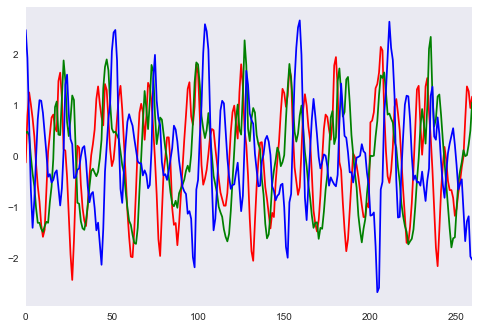

In [11]:
plot_series(X_train[0, :, :])

In [12]:
print(X_train.shape)
print(y_train.shape)

(4075, 260, 3)
(4075, 15)


Can we tell between different people's data by eye?

Let's plot a few series for some different people - say, 5 series for 3 people.

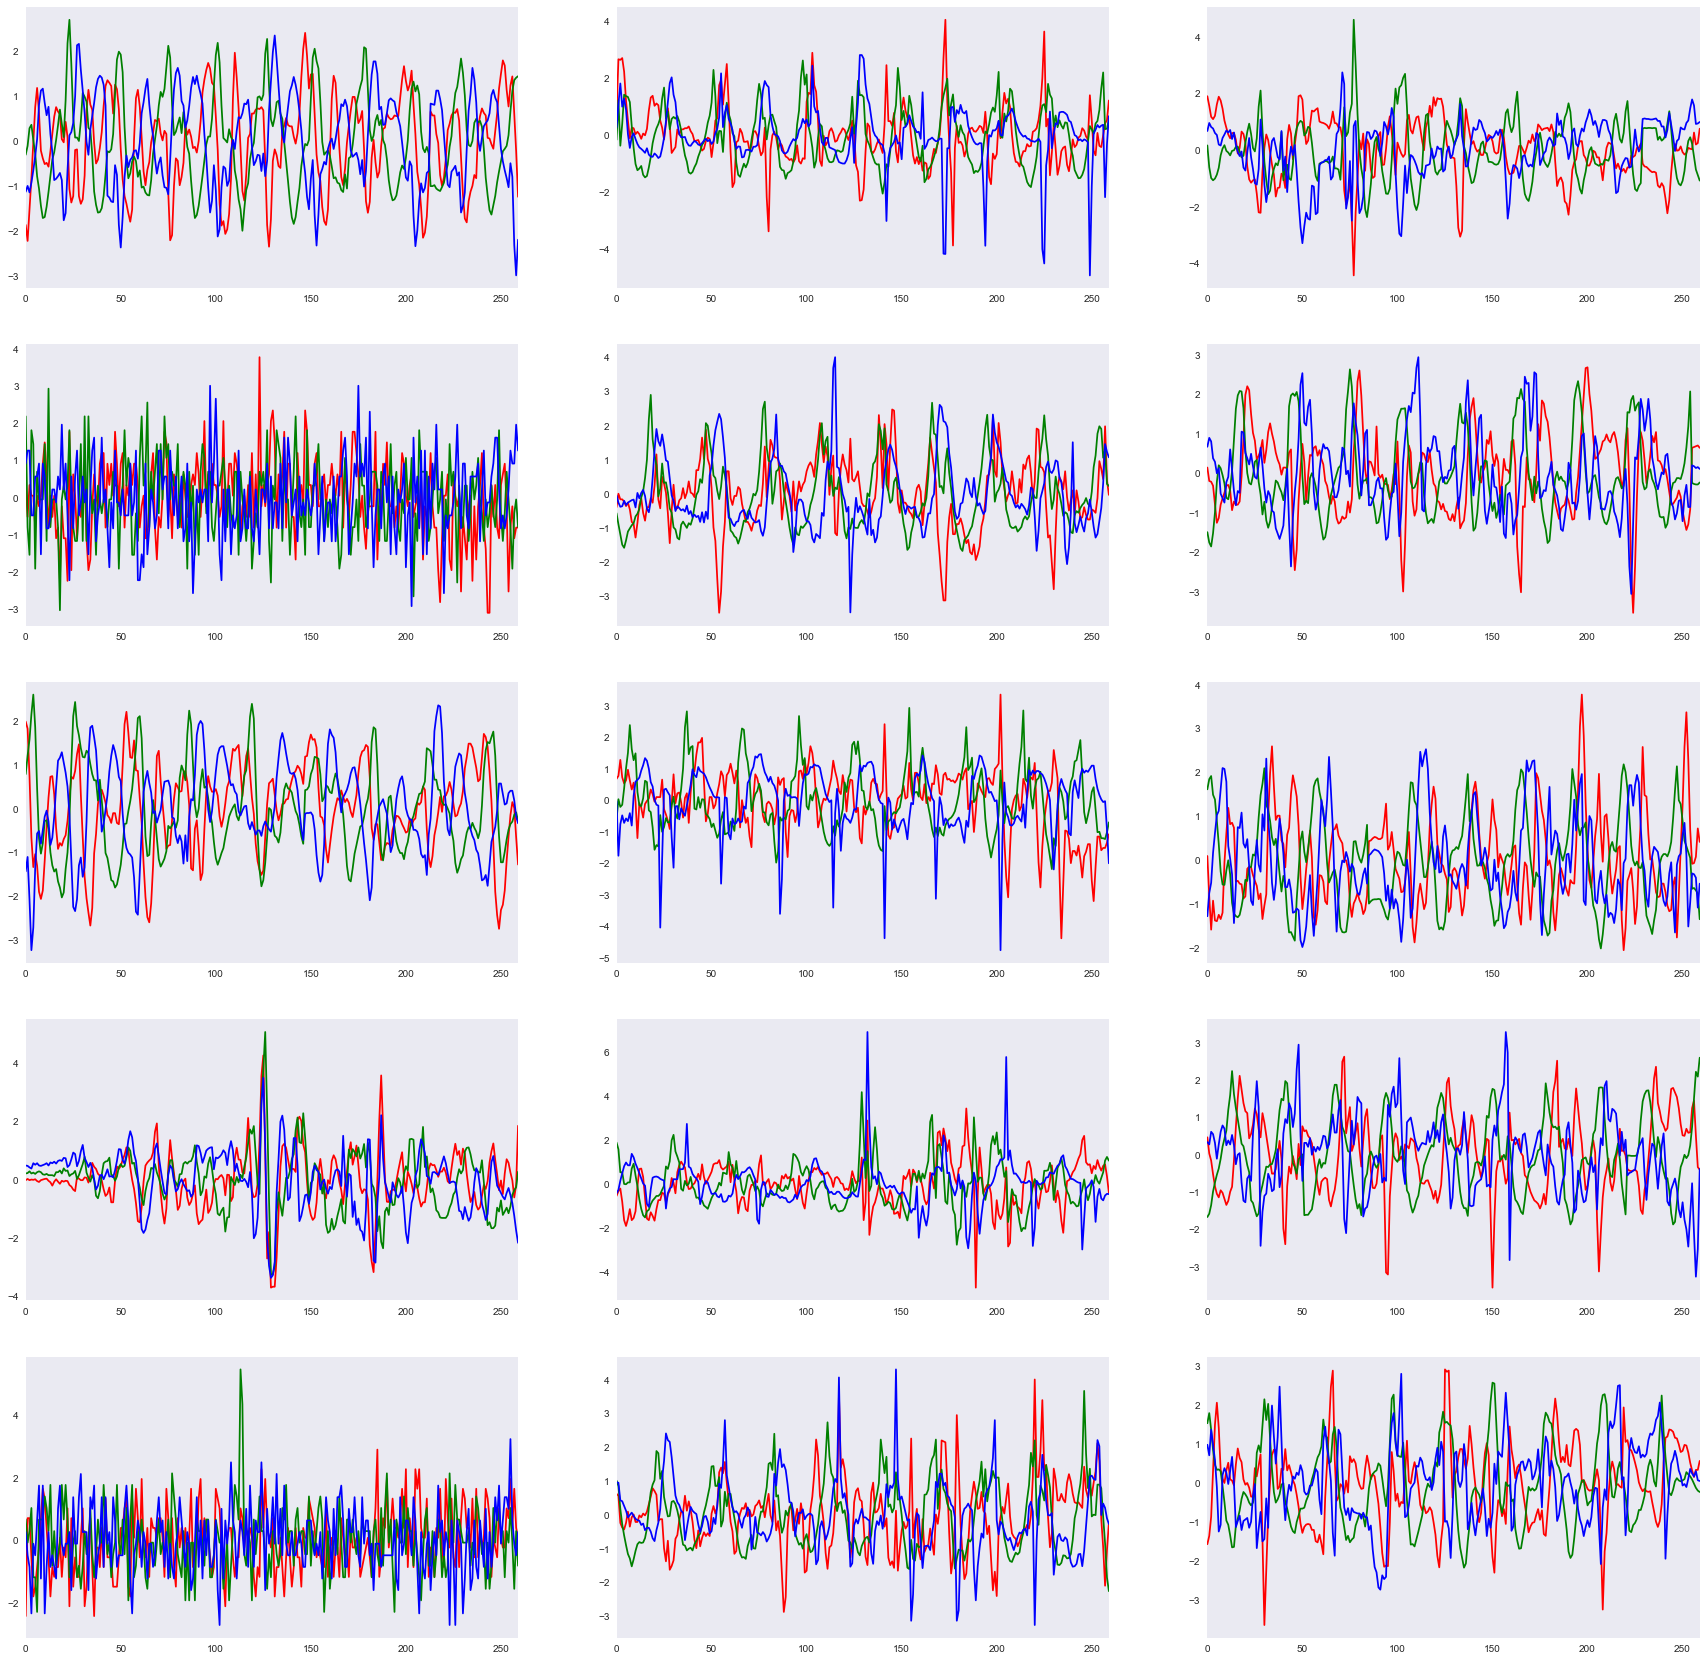

In [13]:
first = np.where(walking[train_indices, 0, 4] == 1)[0]
second = np.where(walking[train_indices, 0, 4] == 2)[0]
third = np.where(walking[train_indices, 0, 4] == 3)[0]

fix, ax = plt.subplots(nrows=5, ncols=3, figsize=(30, 30))

for k in range(5):
    plt.subplot(5, 3, 3*k + 1)
    plot_series(X_train[first[k], :, :])
    
for k in range(5):
    plt.subplot(5, 3, 3*k + 2)
    plot_series(X_train[second[k], :, :])
    
for k in range(5):
    plt.subplot(5, 3, 3*k + 3)
    plot_series(X_train[third[k], :, :])

### The neural network

In [14]:
# Initiate the model - we'll use a sequential model so we can add to it
conv_nn = Sequential()

# Start with a convolutional layer:
#  * filters: The number of "features" we want to learn; number of patterns to try to identify
#  * kernel_size: The "window" to consider, i.e. we look at a rolling window captuiring [kernel_size] time points at once
#  * strides: How many time steps to "roll forward" each time we move the window
#  * activation: The activation function to use; convolutional layers typically use REctified Linear Unit function
#  * input_shape: We're feeding in observations each of shape 260{time points}*3{directional acceleration features}
conv_nn.add(Conv1D(filters=40, kernel_size=40, strides=2, activation="relu", input_shape=(260, 3)))
print(conv_nn.output_shape)

# Another convolutional layer: this one finds "meta-patterns" in the patterns the first layer picked up
conv_nn.add(Conv1D(filters=40, kernel_size=10, activation="relu"))
print(conv_nn.output_shape)

# If the net is too large and computation too slow, we can reduce the number of parameters with max pooling
# This layer would reduce the number of parameters by half by combining ("pooling") parameters
# i.e. parameters get paired up (by position) and the maximum one only is kept
conv_nn.add(MaxPooling1D(pool_size=2))
print(conv_nn.output_shape)

# We still have a 3-dimensional set of parameters - we need to make this 2-dimensional, so we "flatten"
# (Unstack all the leaves and lay them out next to each other)
conv_nn.add(Flatten())
print(conv_nn.output_shape)

# We need to finish with a couple of dense layers: one to detect relationships between the (flattened)
# convolutional neurons, and...
conv_nn.add(Dense(100, activation="sigmoid"))
print(conv_nn.output_shape)

# ... one to present the output as a one-hot vector.
# (We typically use softmax in the very final layer since it provides a "stronger" signal than sigmoid)
conv_nn.add(Dense(15, activation="softmax"))
print(conv_nn.output_shape)

(None, 111, 40)
(None, 102, 40)
(None, 51, 40)
(None, 2040)
(None, 100)
(None, 15)


In [15]:
# We have to compile the network before we can run it, defining:
# * Loss function to use (always categorical cross-entropy for multi-class logistic regression)
# * Optimizer to use
#   ("adam" = "ADAptive Movement estimation", but e.g. "sgd" = "Stochastic Gradient Descent" will work, just slower)
# * Metrics to report (NOT used for adjusting parameters - that's what the loss function is for!)
conv_nn.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
conv_nn.summary()

In [16]:
# Fit it!
# * X_train and y_train are training data/labels
# * epochs: How many times to pass the training data through and update the network's parameters
# * batch_size: How many observations to include in each batch the optimizer sees
# * Also show us the accuracy for the cross-validation set
conv_nn.fit(X_train, y_train, epochs=10, batch_size=100, validation_data=(X_val, y_val))

Train on 4075 samples, validate on 1358 samples
Epoch 1/10
4075/4075 [==============================] - 6s 1ms/step - loss: 2.2312 - acc: 0.2847 - val_loss: 1.4773 - val_acc: 0.5736
Epoch 2/10
4075/4075 [==============================] - 5s 1ms/step - loss: 1.0292 - acc: 0.7524 - val_loss: 0.8415 - val_acc: 0.7931
Epoch 3/10
4075/4075 [==============================] - 5s 1ms/step - loss: 0.6316 - acc: 0.8471 - val_loss: 0.6218 - val_acc: 0.8446
Epoch 4/10
4075/4075 [==============================] - 5s 1ms/step - loss: 0.4415 - acc: 0.9018 - val_loss: 0.4718 - val_acc: 0.8800
Epoch 5/10
4075/4075 [==============================] - 5s 1ms/step - loss: 0.3278 - acc: 0.9313 - val_loss: 0.3914 - val_acc: 0.8918
Epoch 6/10
4075/4075 [==============================] - 5s 1ms/step - loss: 0.2478 - acc: 0.9539 - val_loss: 0.3453 - val_acc: 0.9131
Epoch 7/10
4075/4075 [==============================] - 5s 1ms/step - loss: 0.1853 - acc: 0.9737 - val_loss: 0.3172 - val_acc: 0.9087
Epoch 8/10
407

At this point we could try to improve that cross-validation accuracy score, e.g. change network structure.

### Reporting

In [17]:
from sklearn.metrics import classification_report, confusion_matrix

In [18]:
y_pred = conv_nn.predict_classes(X_test)
print(classification_report(np.argmax(y_test, axis=1), y_pred))
print(confusion_matrix(np.argmax(y_test, axis=1), y_pred))

             precision    recall  f1-score   support

          0       0.96      0.96      0.96       109
          1       0.97      0.96      0.96        92
          2       0.95      0.88      0.91        80
          3       0.94      0.96      0.95       121
          4       0.91      0.91      0.91        70
          5       0.98      0.94      0.96        98
          6       0.87      0.95      0.91        63
          7       0.88      0.94      0.91        88
          8       1.00      0.95      0.98        88
          9       0.97      0.91      0.94        82
         10       0.96      1.00      0.98       101
         11       0.96      0.85      0.91        96
         12       0.98      0.97      0.97        95
         13       0.86      0.96      0.91        77
         14       0.92      0.96      0.94        99

avg / total       0.94      0.94      0.94      1359

[[105   0   1   2   0   0   0   0   0   0   1   0   0   0   0]
 [  0  88   0   0   0   0   1   0

---

## Visualising features

We can try to visualise the "features" of the time series which the convolutional layers of the net have learned to identify.

In [19]:
# Get the values from each layer
layer_dict = dict([(layer.name, layer) for layer in conv_nn.layers])
layer_dict

{'conv1d_1': <keras.layers.convolutional.Conv1D at 0x1ef8e0ee7f0>,
 'conv1d_2': <keras.layers.convolutional.Conv1D at 0x1ef9446c5f8>,
 'dense_1': <keras.layers.core.Dense at 0x1ef94bb7518>,
 'dense_2': <keras.layers.core.Dense at 0x1ef94d96908>,
 'flatten_1': <keras.layers.core.Flatten at 0x1ef94ca6be0>,
 'max_pooling1d_1': <keras.layers.pooling.MaxPooling1D at 0x1ef94c55be0>}

In [20]:
# Plot the weights from a given layer
def plot_filter(layer, k):
    x = layer_dict[layer].get_weights()[0][:, :, k]
    sns.tsplot(x[:, 0], color="red")
    sns.tsplot(x[:, 1], color="green")
    sns.tsplot(x[:, 2], color="blue")

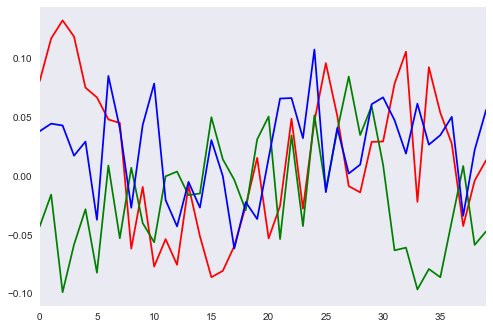

In [21]:
plot_filter("conv1d_1", 3)

We can also see if there are any patterns in the autocorrelation plots which might suggest strong periodicity.

In [22]:
def plot_filter_corr(layer, k):
    x = layer_dict[layer].get_weights()[0][:, :, k]
    t0 = np.correlate(x[:, 0], x[:, 0], mode="full")
    t1 = np.correlate(x[:, 1], x[:, 1], mode="full")
    t2 = np.correlate(x[:, 2], x[:, 2], mode="full")
    sns.tsplot(t0[int(len(t0)/2):], color="red")
    sns.tsplot(t1[int(len(t1)/2):], color="green")
    sns.tsplot(t2[int(len(t2)/2):], color="blue")

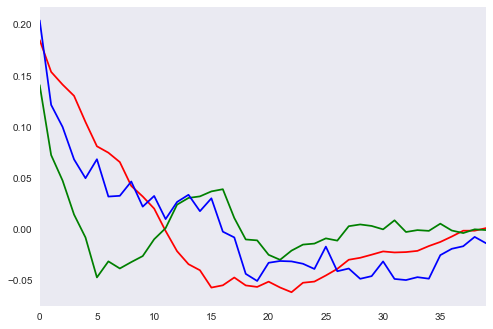

In [23]:
plot_filter_corr("conv1d_1", 8)

Let's plot each filter with its autocorrelation plot.

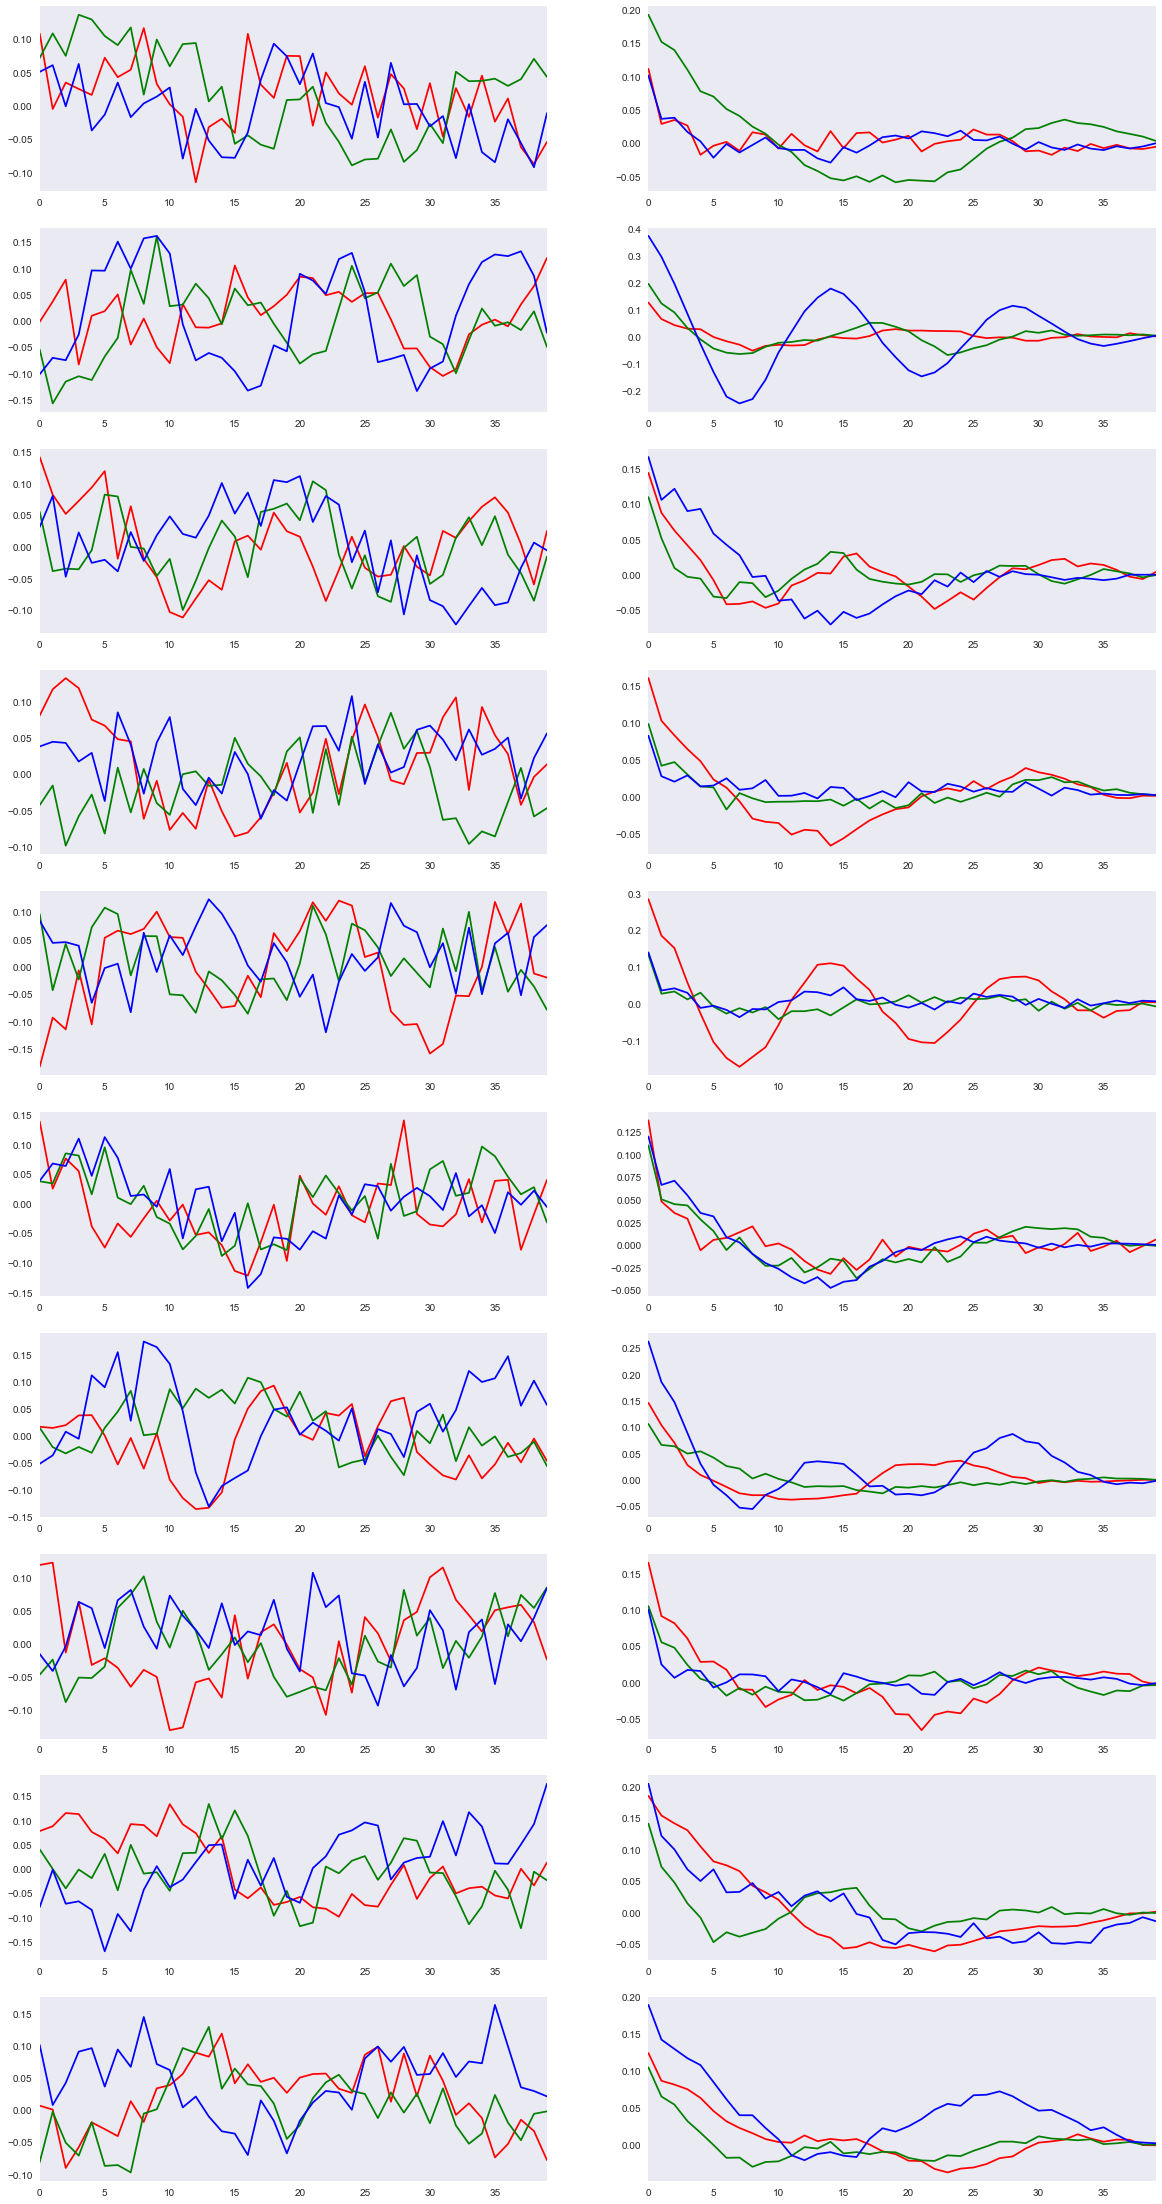

In [24]:
import matplotlib.pyplot as plt

ax, fig = plt.subplots(ncols=2, nrows=10, figsize=(20, 40))

for k in range(10):
    plt.subplot(10, 2, 2*k + 1)
    plot_filter("conv1d_1", k)
    plt.subplot(10, 2, 2*k + 2)
    plot_filter_corr("conv1d_1", k)

---

## Repurposing a previously-trained model

If we take off the final fully-connected layers of the network, we can train a new network making use of the convolutional features we've already learned.

In [25]:
# Remove the last layer in the model (the output layer)
conv_nn.pop()
# Remove 1 more (the first fully connected layer)
conv_nn.pop()

conv_nn.add(Dense(1, activation = "linear"))
#... etc.